In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import logging
import warnings

#logging.getLogger("tensorflow").setLevel(logging.ERROR)
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

Este notebook implementa duas arquiteturas de redes neurais convolucionais para classificação no dataset CIFAR-100. O código começa com as importações necessárias, incluindo TensorFlow, NumPy e Matplotlib, além de configurações para suprimir avisos e logs desnecessários.

carrega o dataset CIFAR-100 usando a função integrada do Keras, que retorna imagens de 32x32 pixels com 3 canais de cor, divididas em 100 classes diferentes. Os dados são normalizados dividindo os valores dos pixels por 255.0 para ficarem no intervalo [0,1], o que ajuda na convergência do treinamento.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()


x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


A primeira arquitetura implementada é uma CNN densa tradicional na função create_improved_model(). Esta rede possui quatro blocos convolucionais progressivos, começando com 64 filtros no primeiro bloco e dobrando a cada bloco (128, 256, 512). Cada bloco contém duas camadas convolucionais 3x3 com ativação Relu. O dropout aumenta progressivamente de 0.25 para 0.5 entre os blocos para prevenir overfitting.

In [3]:
def create_improved_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),

        # Bloco 1
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Bloco 2
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Bloco 3
        tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Bloco 4
        tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),

        # Classificador
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation='softmax')
    ])
    return model

In [ ]:
# -------------------------------------------------------------------
# 1) Configurações gerais (hiperparâmetros, caminhos, etc)
# -------------------------------------------------------------------

EPOCHS       = 50
BATCH_SIZE   = 64
VALID_SPLIT  = 0.1
MODEL_PATH   = "best_cifar100_model.h5"
TFLITE_PATH  = "cifar100_simple.tflite"
PATIENCE_ES  = 10
MONITOR_MET  = "val_loss"

In [ ]:
# -------------------------------------------------------------------
# 2) Helpers
# -------------------------------------------------------------------
def get_callbacks():
        return [
            EarlyStopping(monitor=MONITOR_MET, patience=PATIENCE_ES, verbose=0, restore_best_weights=True),
            ModelCheckpoint(MODEL_PATH, monitor=MONITOR_MET, save_best_only=True, verbose=0),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7
            )
        ]
def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history[MONITOR_MET], label="val")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

def evaluate_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia final no test set: {acc:.4f}")
    return loss, acc

def export_tflite(model, filename="cifar100_simple.tflite"):
    print(f"Convertendo modelo para TFLite em `{filename}`...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(filename, "wb") as f:
        f.write(tflite_model)
    print("✅ Export concluído.")
    #return tflite_model

A primeira sessão de treinamento inclui data augmentation para diversificar o conteudo que o modelo verá ao longo do treino.
 O modelo é compilado com otimizador AdamW com  taxa de aprendizado inicial de 0.001 e weight decay de 0.0001. O treinamento usa o gerador de dados aumentados e valida no conjunto de teste original.

🔨 Criando e compilando modelo para CIFAR-100


I0000 00:00:1751837639.382989      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,009,060 (19.11 MB)

 Trainable params: 5,004,196 (19.09 MB)

 Non-trainable params: 4,864 (19.00 KB)


🚂 Iniciando treino por 50 epochs (batch size=64)
Epoch 1/50


I0000 00:00:1751837649.889673      96 service.cc:148] XLA service 0x7fee34009fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751837649.890774      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751837650.806885      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/781 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.0243 - loss: 5.6786 

I0000 00:00:1751837658.643281      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/781 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.0449 - loss: 4.8490 - val_accuracy: 0.0776 - val_loss: 4.5016 - learning_rate: 0.0010
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1094 - loss: 4.0139 - val_accuracy: 0.0739 - val_loss: 4.5781 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.1208 - loss: 3.8478 - val_accuracy: 0.1225 - val_loss: 4.2630 - learning_rate: 0.0010
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2188 - loss: 3.1073 - val_accuracy: 0.1210 - val_loss: 4.2932 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.1920 - loss: 3.3389 - val_accuracy: 0.2558 - val_loss: 3.0203 - learning_rate: 0.0010
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2969 - loss: 3.0405 - val_accuracy: 0.2547 - val_loss: 3.0310 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.2492 - loss: 2.9749 - val

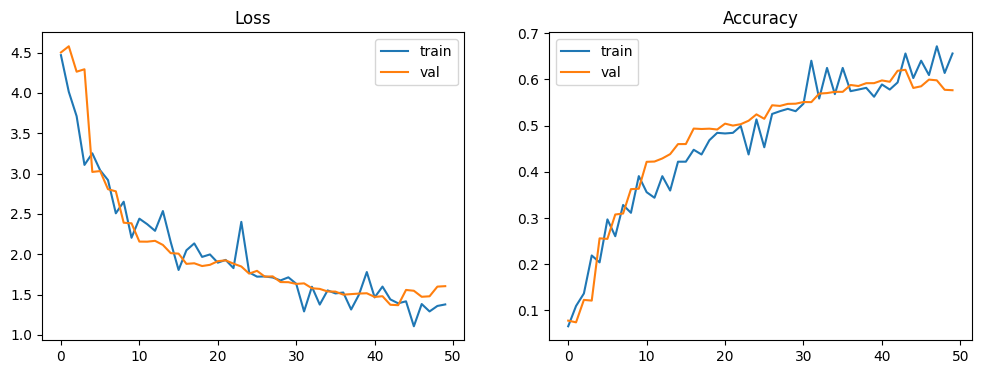


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.6209
Convertendo modelo para TFLite em `cifar100_simple.tflite`...
Saved artifact at '/tmp/tmpcddkc9fc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  140665404413072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404412880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404413840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404411152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404414608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404414224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404415760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404416336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140665404416528: Tensor

W0000 00:00:1751838357.166333      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751838357.166369      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751838357.192571      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ Export concluído.


In [6]:
# -------------------------------------------------------------------
# 3) O  main, orquestrando tudo CNN DENSA
# -------------------------------------------------------------------
# 3.1 Cria, compila e mostra sumário
print("🔨 Criando e compilando modelo para CIFAR-100")
model = create_improved_model()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True,
zoom_range=0.1
)
datagen.fit(x_train)


model.compile(
optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
loss="sparse_categorical_crossentropy",
metrics=["accuracy"]
)
model.summary()

# 3.2 Treina com callbacks
print(f"\n🚂 Iniciando treino por {EPOCHS} epochs (batch size={BATCH_SIZE})")
history = model.fit(
datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
steps_per_epoch=len(x_train) // BATCH_SIZE,
epochs=EPOCHS,
validation_data=(x_test, y_test),  
callbacks=get_callbacks(),
verbose=1
)

# 3.3 Exibe gráficos de evolução
print("\n📊 Plotando curva de treino")
plot_history(history)

# 3.4 Avaliação final
print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

# 3.5 Exporta para TFLite
export_tflite(model, TFLITE_PATH)

# ResNet Style

A segunda arquitetura implementa um estilo ResNet mais moderno. O código começa configurando mixed precision para acelerar o treinamento em GPUs modernas, usando float16 para cálculos forward e backward, mas mantendo float32 para atualizações dos pesos. As regularizações são definidas como constantes. O restante do codigo é muito parecido com o anterior, com apenas a arquitetura do modelo sendo alterada para um novo treinamento do zero.

In [6]:
# ResNet Style

import tensorflow as tf
from tensorflow.keras import layers, regularizers, mixed_precision

mixed_precision.set_global_policy('mixed_float16')

L2  = regularizers.l2(1e-4)
HE  = 'he_normal'

def _conv_bn_relu(x, f, k=3, s=1):
    x = layers.Conv2D(f, k, s, 'same', use_bias=False,
                      kernel_initializer=HE, kernel_regularizer=L2)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def _residual(x, f, s):
    y = _conv_bn_relu(x, f, 3, s)
    y = layers.Conv2D(f, 3, padding='same', use_bias=False,
                      kernel_initializer=HE, kernel_regularizer=L2)(y)
    y = layers.BatchNormalization()(y)
    if s != 1 or x.shape[-1] != f:
        x = layers.Conv2D(f, 1, s, 'same', use_bias=False,
                          kernel_initializer=HE, kernel_regularizer=L2)(x)
        x = layers.BatchNormalization()(x)
    y = layers.add([y, x])
    return layers.ReLU()(y)

def create_improved_model():
    inp = layers.Input((32, 32, 3))
    x   = _conv_bn_relu(inp, 64)
    for _ in range(3): x = _residual(x, 64, 1)
    x = _residual(x, 128, 2);  x = _residual(x, 128, 1); x = _residual(x, 128, 1)
    x = _residual(x, 256, 2);  x = _residual(x, 256, 1); x = _residual(x, 256, 1)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(100, 'softmax', dtype='float32',
                       kernel_initializer=HE)(x)
    return tf.keras.Model(inp, out, name='cifar100_resnet_like')


🔨 Criando e compilando modelo para CIFAR-100


I0000 00:00:1751839753.424448      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "cifar100_resnet_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,728 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 4,357,156 (16.62 MB)

 Trainable params: 4,350,884 (16.60 MB)

 Non-trainable params: 6,272 (24.50 KB)


🚂 Iniciando treino por 50 epochs (batch size=64)
Epoch 1/50


I0000 00:00:1751839772.327265      94 service.cc:148] XLA service 0x7e64c4017ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751839772.328152      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751839774.263212      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/781 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0191 - loss: 6.2490   

I0000 00:00:1751839784.729165      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/781 ━━━━━━━━━━━━━━━━━━━━ 73s 56ms/step - accuracy: 0.0938 - loss: 4.6456 - val_accuracy: 0.1291 - val_loss: 4.7210 - learning_rate: 0.0010
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1406 - loss: 3.8008 - val_accuracy: 0.1232 - val_loss: 4.7869 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.2507 - loss: 3.4812 - val_accuracy: 0.2873 - val_loss: 3.3569 - learning_rate: 0.0010
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3281 - loss: 3.0677 - val_accuracy: 0.2834 - val_loss: 3.3805 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.3580 - loss: 2.9028 - val_accuracy: 0.3423 - val_loss: 3.0348 - learning_rate: 0.0010
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3125 - loss: 3.3846 - val_accuracy: 0.3526 - val_loss: 2.9996 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.4252 - loss: 2.6155 - val

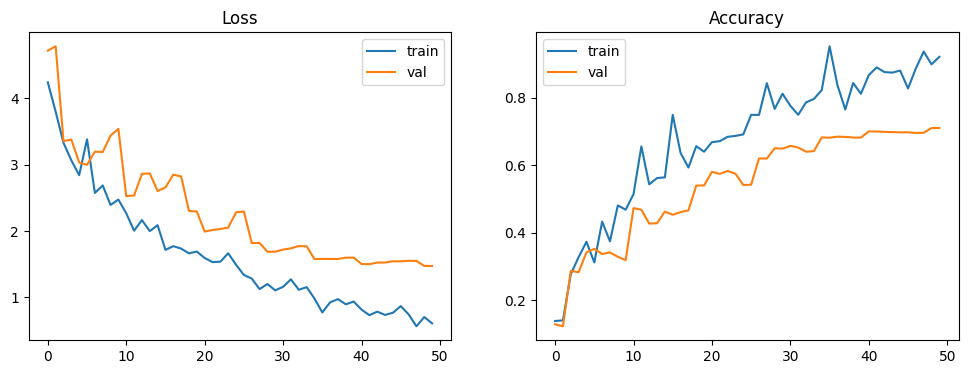


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.7111


(1.4747406244277954, 0.7110999822616577)

In [7]:
# -------------------------------------------------------------------
# 3) O  main, orquestrando tudo O3
# -------------------------------------------------------------------
# 3.1 Cria, compila e mostra sumário
print("🔨 Criando e compilando modelo para CIFAR-100")
model = create_improved_model()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True,
zoom_range=0.1
)
datagen.fit(x_train)


model.compile(
optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
loss="sparse_categorical_crossentropy",
metrics=["accuracy"]
)
model.summary()

# 3.2 Treina com callbacks
print(f"\n🚂 Iniciando treino por {EPOCHS} epochs (batch size={BATCH_SIZE})")
history = model.fit(
datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
steps_per_epoch=len(x_train) // BATCH_SIZE,
epochs=EPOCHS,
validation_data=(x_test, y_test),  
callbacks=get_callbacks(),
verbose=1
)

# 3.3 Exibe gráficos de evolução
print("\n📊 Plotando curva de treino")
plot_history(history)

# 3.4 Avaliação final
print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

# 3.5 Exporta para TFLite
#export_tflite(model, TFLITE_PATH)